In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
import os
import re
import string
from nltk.tokenize import sent_tokenize
from nltk.tokenize.punkt import PunktSentenceTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import numpy.linalg
from math import ceil,floor
import math
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from rouge import Rouge

np.set_printoptions(suppress=True)
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

sns.set_style('whitegrid')
sns.set_context('talk')

In [6]:
path = '../data/cnn/stories'

file_loc  = os.path.join(path, "0bb71d989b199a24d540180bdba439351bfa4dc0.story")

file = open(file_loc)
text = file.read()

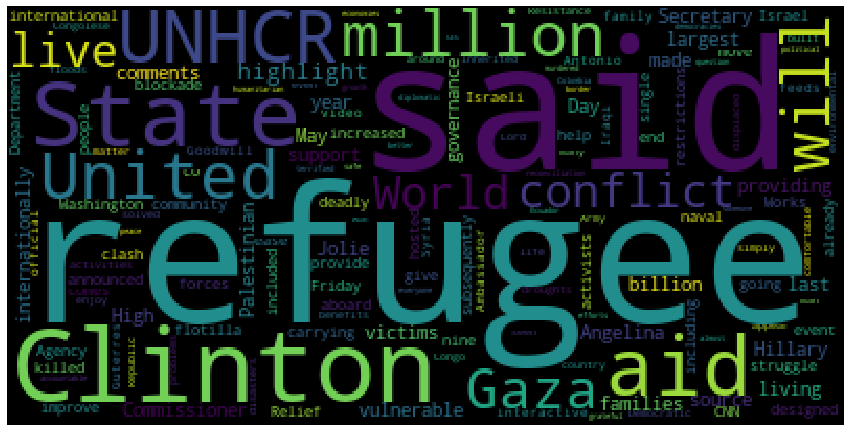

In [7]:
#Generating word cloud of the text
wc = WordCloud().generate(text)
plt.rcParams['figure.figsize'] = 15,10
plt.imshow(wc)
plt.axis("off")
plt.show()


# Text preprocessing

The following pre processing steps were carried out:
1. Separate the story and the highlights from the document
2. Remove the location and CNN heading
3. Split the document into sentences. Observe any odd splits and include them in the abbreviation  of the tokenizer
4. Remove punctuation and stop words
5. Perform Lemmatization
6. Perform Tf Idf vectorization
7. Perform LSA using SVD

In [8]:
#Function to remove '\n' and separate the highlights
def separate_highlights(text):
    text = text.replace('economies.','economies,')
    split = text.split('@highlight')
    highlights = '.'.join(split[1:])
    highlights = highlights.replace("\n","")
    story = split[0]
    story = story.replace("\n"," ")
    
    return highlights,story
    

In [9]:
#Function to get remove the location and CNN heading
def remove_heading(text):
    index = text.find('(CNN)')
    l = len('(CNN)')
    if index < 0:
        return text
    else:
        return text[index+l:].strip(' --')
    
    

In [10]:
#Split the document into sentences
def split_sentences(text):
    
    tokenizer = PunktSentenceTokenizer()
    
    #Add 'no' abbreviation to the tokenizer so it doesn't split on 'No.1'
    tokenizer._params.abbrev_types.add('no')
    tokenizer._params.abbrev_types.add('st')
    tokenizer._params.abbrev_types.add('co')
    
    return tokenizer.tokenize(text)
    

In [11]:
def dict_sentences(list_sentences):
    dictionary = {i:list_sentences[i] for i in range(len(list_sentences))}
    return dictionary

In [12]:
#Remove punctuation from the sentences
def remove_punc(list_sentences):
    table = str.maketrans('','',string.punctuation)            
    for i in range(len(list_sentences)):
        list_sentences[i] = list_sentences[i].translate(table)
    return list_sentences
        

In [13]:
def remove_stopwords(sentence):
    
    stop_words = set(stopwords.words('english'))
    tokens = sentence.split()
    tokens = [i for i in tokens if i.isalpha()]
    tokens = [i.lower() for i in tokens]
    tokens = [i for i in tokens if i not in stop_words]
    sentence = ' '.join(tokens)
    return sentence

In [14]:
def lemmatizer(sentence):
    tokens = sentence.split()
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(i) for i in tokens]    
    sentence = ' '.join(tokens)
    return sentence
    
    

In [15]:
def tfidf_vectorizer(sentences):
    
    vectorizer = TfidfVectorizer(ngram_range = (1,1))
    tfidf_matrix = vectorizer.fit_transform(sentences)
    df = pd.DataFrame(tfidf_matrix.toarray(),columns = vectorizer.get_feature_names())
    
    return tfidf_matrix,df

In [16]:
def svd(tfidf_matrix):
    tdm = tfidf_matrix.T.toarray()
    U,S,Vt = np.linalg.svd(tdm)
    
    tsm = Vt
    tsm_df = pd.DataFrame(tsm.round(5))
    return tsm, tsm_df, S
    

# Sentence Selection Method 1 : Gong and Liu

In VT matrix, row order indicates the importance of the concepts, such that the first row represents the most important concept extracted. The cell values of this matrix show the relation between the sentence and the concept. A higher cell value indicates that the sentence is more related to the concept.
In the approach of Gong and Liu, one sentence is chosen from the most important concept, and then a second sen- tence is chosen from the second most important concept until a predefined number of sentences are collected.

In [17]:
def sentence_selection_1(tsm_df,k):
    tsm_df = tsm_df.iloc[:k,:]
    temp = list((tsm_df.idxmax(axis = 1)))
    sent_selected = []
    #Remove duplicated sentences
    for index in temp:
        if index not in sent_selected:
            sent_selected.append(index)
    summary = ""
    for i in sent_selected:
        summary = summary + " " + orig_dict[i]
      
    return summary
    

# Sentence Selection Method 2 : Steinberger and Jezek

In this approach, the length of each sentence vector, represented by the row of V matrix, is used for sentence selec- tion. For each sentence vector in matrix V (its components are multiplied by corresponding singular values) we compute its length. The reason of the multiplication is to favor the index values in the matrix V that correspond to the highest singular values (the most significant topics). The sentence with the highest length value is chosen to be a part of the resulting summary.

In [18]:
def sentence_selection_2(tsm,S,k):
    
    s_square = tuple(s**2 if i < k else 0.0 for i,s in enumerate(S))
    scores = {}
    for i,row in enumerate(tsm.T):
        score = sum(s2*(v**2) for s2,v in zip(s_square,row))
        scores[i]=math.sqrt(score)
        
    summary = ""
    for num,sent_index in enumerate(sorted(scores,key = scores.get,reverse=True)):
        if num < k:
            
            summary = summary + " " + orig_dict[sent_index]
    
    return summary

# Sentence selection method 3 : Ozsoy et al. Cross method

For each concept, which is represented by the rows of the VT matrix, the average sentence score is calculated. Then the cell values which are less than or equal to the average score are set to zero. After pre-processing, the steps of Steinberger and Jezek approach are followed with a modification. In our cross approach, the total length of each sentence vector, which is represented by a column of the VT matrix, is calculated. While calculating the length score, the parameter of number of concepts to be used is given by the user; if it is not given, all of the extracted concepts are used. Then, the longest sentence vectors are collected as a part of the resulting summary.

In [19]:
def sentence_selection_3(tsm_df,S,k):
    
    #Pre processing step. 
    def func(row):
        mean = row.mean()
        for i in range(len(row)):
            if row[i] <= mean:
                row[i] = 0
            else:
                row[i] = row[i]
        return row
    
    tsm_df.apply(func,axis = 1,result_type = 'broadcast')
    
    tsm = tsm_df.values
    
    return sentence_selection_2(tsm,S,k)  

# Sentence selection method 4 : Ozsoy et al. topic method

The pre-processing step of this approach starts in a similar way to the pre-processing step to the cross approach. First, the average sentence score is calculated for each concept using the row of the VT matrix. Then the cell values less than this score are set to zero. Next step, a concept × con- cept matrix is created by finding out the concepts that have common sentences. The common sentences are the ones that have cell values other than zero in both concepts that are considered. Then the new cell values of the concept × con- cept matrix are set to the total of common sentence scores. After the creation of the concept × concept matrix, the strength of each concept is calculated. For each con- cept, the strength value is computed by getting the cumulative cell values for each row of the concept × concept matrix. The concept with the highest strength value is chosen as the main topic of the input document. After these steps, the sentences are collected from the pre-processed VT matrix following the approach of Gong and Liu.

In [20]:
def sentence_selection_4(tsm,tsm_df,k):
    
    def func(row):
        mean = row.mean()
        for i in range(len(row)):
            if row[i] <= mean:
                row[i] = 0
            else:
                row[i] = row[i]
        return row

    temp  = tsm_df.copy()    
    temp.apply(func,axis = 1,result_type = 'broadcast')
    
    def function(u,v):
        value = 0
        for i, j in zip(u,v):
            if (i!=0) and (j!=0):
                value = value + (i+j)
            else:
                value = value
        return value
    
    tsm_sum = temp.sum(axis = 1)
    tsm_sum = (tsm_sum*2).values
    tsm_sum_diag = np.diag(tsm_sum)
    concept_concept = squareform(pdist(temp,function)) + tsm_sum_diag
    
    concept_concept_df = pd.DataFrame(concept_concept)
    concept_concept_df['strength'] = concept_concept_df.sum(axis = 1)
    
    imp_concepts = concept_concept_df.sort_values(by = 'strength',ascending = False).index
    
    imp_concepts = imp_concepts[:k]
    tsm_df = tsm_df.loc[imp_concepts]
    
    return sentence_selection_1(tsm_df,k)   

# Sentence selection method 5 : Graph based TextRank

In [21]:
def textrank(tfidf_matrix,k,length_sentences):
   
    sim_mat = np.zeros([length_sentences,length_sentences])
    
    for i in range(length_sentences):
        for j in range(length_sentences):
            if i != j:
                sim_mat[i][j] = cosine_similarity(tfidf_matrix[i],tfidf_matrix[j])
                
    nx_graph = nx.from_numpy_array(sim_mat)
    scores = nx.pagerank(nx_graph)
    
    summary = ""
    
    for num,sent_index in enumerate(sorted(scores,key = scores.get,reverse=True)):
        if num < k:

            summary = summary + " " + orig_dict[sent_index]
            
    return summary

# Topic modeling visualization

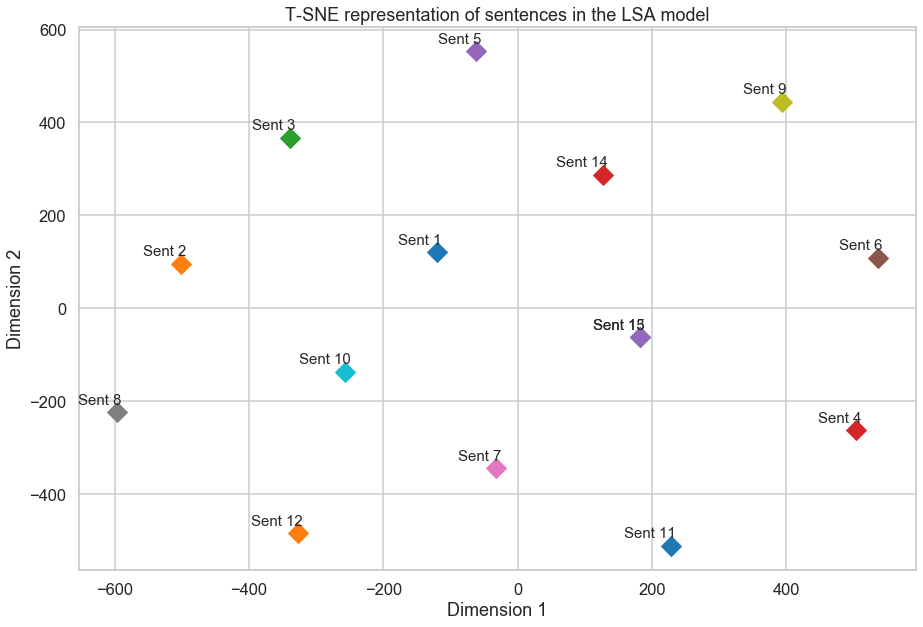

In [22]:
highlights,story  = separate_highlights(text)
story = remove_heading(story)
sentences = split_sentences(story)
orig_dict = dict_sentences(sentences)
length = len(orig_dict)


for i in range(len(sentences)):
    sentences[i] = remove_stopwords(sentences[i])
    sentences[i] = lemmatizer(sentences[i])

tfidf_matrix,df = tfidf_vectorizer(sentences)

svd_model = TruncatedSVD(n_components=5, algorithm='randomized', n_iter=100, random_state=122)

new_matrix = svd_model.fit_transform(tfidf_matrix)

tsne = TSNE(n_components = 2, init = 'pca',n_iter = 500,random_state = 7)
new_rep = tsne.fit_transform(new_matrix)

x =[]
y = []
for value in new_rep:
    x.append(value[0])
    y.append(value[1])

for i in range(len(x)):
    plt.plot(x[i],y[i],markersize = 14,marker = 'D')
    plt.annotate('Sent {}'.format(i+1),xy = (x[i],y[i]),xytext=(5, 5),
                 textcoords='offset points',ha = 'right',va = 'bottom',fontsize = 15)

plt.title("T-SNE representation of sentences in the LSA model")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

# Extracting summaries

In this case, the length of the summary is chosen to 15% of the length of the original document

In [29]:
tsm,tsm_df,S = svd(tfidf_matrix)
    
    
print("==================================================Original text======================================================")
print("\n",text)

print("\n\n=================================================Highlights==========================================================")
print("\n",highlights)

print("\n\n==========================================Summary from Gong ang Liu Approach=========================================")
summary1 = sentence_selection_1(tsm_df,floor(0.15*length))
print("\n",summary1)

print("\n\n========================================Summary from Steinberger and Jezek approach==================================")
summary2 = sentence_selection_2(tsm,S,floor(0.15*length))
print("\n",summary2)

print("\n\n======================================Summary from Ozsoy et al. Cross method approach================================")
summary3 = sentence_selection_3(tsm_df,S,floor(0.15*length))
print("\n",summary3)

print("\n\n======================================Summary from Ozsoy et al. Topic method approach================================")
summary4 = sentence_selection_4(tsm,tsm_df,floor(0.15*length))
print("\n",summary4)

print("\n\n=====================================Summary from Graph based TextRank algorithm approach============================")
summary5 = textrank(tfidf_matrix,floor(0.15*length),length)
print("\n",summary5)

==================================================Original text======================================================

 Washington (CNN) -- Secretary of State Hillary Clinton announced the United States will give $60 million to the U.N. Relief and Works Agency for help to Palestinian refugees on Friday, a move designed to improve the lives of 4.7 million people.

The aid comes as the United States and the international community struggle to provide increased aid to Palestinians living in Gaza. In May, in a deadly clash aboard a flotilla carrying aid to Gaza, Israeli forces killed nine activists. Israel subsequently has said it will ease restrictions on aid going into Gaza but will not end its naval blockade.

The United States already is the largest single source of support for refugees and refugees and victims of conflict internationally, Clinton said, providing $1.7 billion last year, including $640 million for the U.N. High Commissioner for Refugees, or the UNHCR.

Clinton made the 

# Evaluation using ROUGE score

In [30]:
r = Rouge()

rouge_1_f = []
rouge_L_f = []

for summary in [summary1,summary2, summary3, summary4, summary5]:
    scores = r.get_scores(summary,highlights)
    rouge_1_f.append(scores[0]['rouge-1']['f'])
    rouge_L_f.append(scores[0]['rouge-l']['f'])

In [31]:
scores_df = pd.DataFrame({'ROUGE-1 F-measure':rouge_1_f,'ROUGE-L F-measure':rouge_L_f},
             index = ['Gong and Liu approach','Steinberger and Jezek approach',
                      'Ozsoy et al Cross method','Ozsoy et al Topic method','TextRank algorithm']).T

display(scores_df)

,Gong and Liu approach,Steinberger and Jezek approach,Ozsoy et al Cross method,Ozsoy et al Topic method,TextRank algorithm
ROUGE-1 F-measure,0.246914,0.087912,0.257143,0.349206,0.539326
ROUGE-L F-measure,0.250000,0.083333,0.266667,0.346154,0.588235
